In [1]:
from google.colab import files
files.upload()  # Upload the kaggle.json file here
print("*******")

Saving kaggle.json to kaggle.json
*******


In [2]:
!pip install kaggle -Uqq
!mkdir -p /root/.config/kaggle
!mv kaggle.json /root/.config/kaggle/
!chmod 600 /root/.config/kaggle/kaggle.json


In [3]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor,export_graphviz
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [4]:
path = Path('bluebook-for-bulldozers')
if not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [5]:
path.ls(file_type='text')

(#7) [Path('bluebook-for-bulldozers/ValidSolution.csv'),Path('bluebook-for-bulldozers/Valid.csv'),Path('bluebook-for-bulldozers/median_benchmark.csv'),Path('bluebook-for-bulldozers/Machine_Appendix.csv'),Path('bluebook-for-bulldozers/random_forest_benchmark_test.csv'),Path('bluebook-for-bulldozers/TrainAndValid.csv'),Path('bluebook-for-bulldozers/Test.csv')]

In [6]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [7]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [8]:
for c in df.columns:
  print(c,df[c].unique().shape[0])

SalesID 412698
SalePrice 954
MachineID 348808
ModelID 5281
datasource 6
auctioneerID 31
YearMade 73
MachineHoursCurrentMeter 15634
UsageBand 4
saledate 4013
fiModelDesc 5059
fiBaseModel 1961
fiSecondaryDesc 178
fiModelSeries 124
fiModelDescriptor 141
ProductSize 7
fiProductClassDesc 74
state 53
ProductGroup 6
ProductGroupDesc 6
Drive_System 5
Enclosure 7
Forks 3
Pad_Type 5
Ride_Control 4
Stick 3
Transmission 9
Turbocharged 3
Blade_Extension 3
Blade_Width 7
Enclosure_Type 4
Engine_Horsepower 3
Hydraulics 13
Pushblock 3
Ripper 5
Scarifier 3
Tip_Control 4
Tire_Size 18
Coupler 4
Coupler_System 3
Grouser_Tracks 3
Hydraulics_Flow 4
Track_Type 3
Undercarriage_Pad_Width 20
Stick_Length 30
Thumb 4
Pattern_Changer 4
Grouser_Type 4
Backhoe_Mounting 3
Blade_Type 11
Travel_Controls 8
Differential_Type 5
Steering_Controls 6


In [9]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [10]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True)

,ProductSize
0,NaN
1,Medium
2,NaN
3,Small
4,NaN
...,...
412693,Mini
412694,Mini
412695,Mini
412696,Mini


In [11]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

In [12]:
df = add_datepart(df, 'saledate')
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)
/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)


In [13]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [14]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [15]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [16]:
procs = [Categorify, FillMissing]
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [17]:
len(to.train),len(to.valid)

(404710, 7988)

In [18]:
to.show(2)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807


In [19]:
to.items.head(2)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1


In [20]:
to.classes['ProductSize']

['#na#', 'Compact', 'Large', 'Large / Medium', 'Medium', 'Mini', 'Small']

In [21]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [22]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

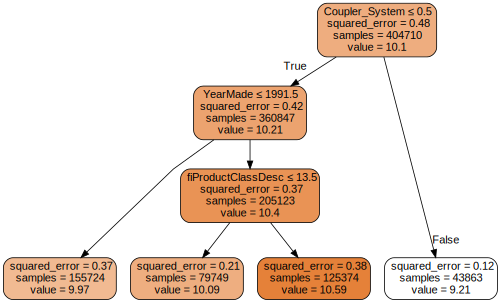

In [23]:
draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

In [24]:
!pip uninstall -y dtreeviz
!pip install dtreeviz==2.2.1

Found existing installation: dtreeviz 2.2.1
Uninstalling dtreeviz-2.2.1:
  Successfully uninstalled dtreeviz-2.2.1
  Using cached dtreeviz-2.2.1-py3-none-any.whl.metadata (2.4 kB)
Using cached dtreeviz-2.2.1-py3-none-any.whl (91 kB)


In [25]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

In [26]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

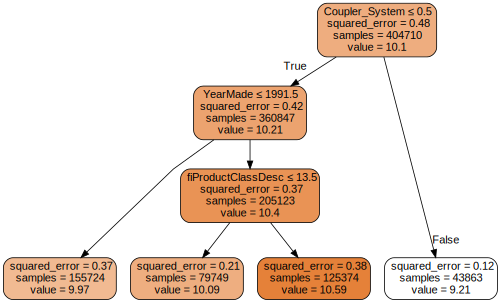

In [27]:
draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


IndexError: string index out of range

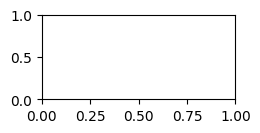

In [28]:
import dtreeviz
samp_idx = np.random.permutation(len(y))[:500]

viz_model = dtreeviz.model(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var)
viz_model.view()

In [29]:
print(f"Model expects {m.n_features_in_} features")
print(f"xs has {xs.shape[1]} columns")
assert m.n_features_in_ == xs.shape[1]
assert isinstance(xs, pd.DataFrame)
print(f"Max feature index in tree: {max(m.tree_.feature)}")
print(f"Number of columns: {len(xs.columns)}")
print(type(dep_var))

Model expects 66 features
xs has 66 columns
Max feature index in tree: 57
Number of columns: 66
<class 'str'>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


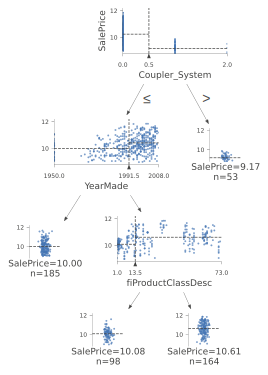

In [30]:
X_sample = xs.iloc[samp_idx]  # DataFrame with column names
y_sample = y.iloc[samp_idx]   # Series

feature_names = list(xs.columns.astype(str))  # Explicitly ensure string list

viz_model = dtreeviz.model(
    m,
    X_sample,
    y_sample,
    feature_names=feature_names,
    target_name=str(dep_var)  # Ensure this is a string
)
viz_model.view()

In [37]:
m2 = DecisionTreeRegressor(min_samples_leaf=25)
m2.fit(xs, y);

In [38]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [39]:
m_rmse(m2, xs, y)


0.210356

In [40]:
m_rmse(m2, valid_xs, valid_y)

0.263511

In [41]:
m2.get_n_leaves(), len(xs)

(np.int64(12434), 404710)

In [42]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [43]:
mf = rf(xs, y);

In [44]:
m_rmse(mf, xs, y), m_rmse(mf, valid_xs, valid_y)

(0.171498, 0.233054)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature name

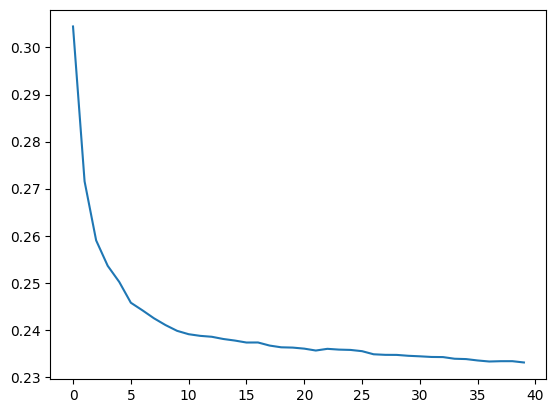

In [48]:
preds = np.stack([t.predict(valid_xs) for t in mf.estimators_])
r_mse(preds.mean(0), valid_y)
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [50]:
r_mse(mf.oob_prediction_, y)

0.211365

In [51]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [52]:
fi = rf_feat_importance(mf, xs)
fi[:10]

,cols,imp
57,YearMade,0.172642
30,Coupler_System,0.111634
6,ProductSize,0.100733
7,fiProductClassDesc,0.079062
54,ModelID,0.060917
31,Grouser_Tracks,0.053696
65,saleElapsed,0.050631
3,fiSecondaryDesc,0.043959
12,Enclosure,0.040395
32,Hydraulics_Flow,0.040391


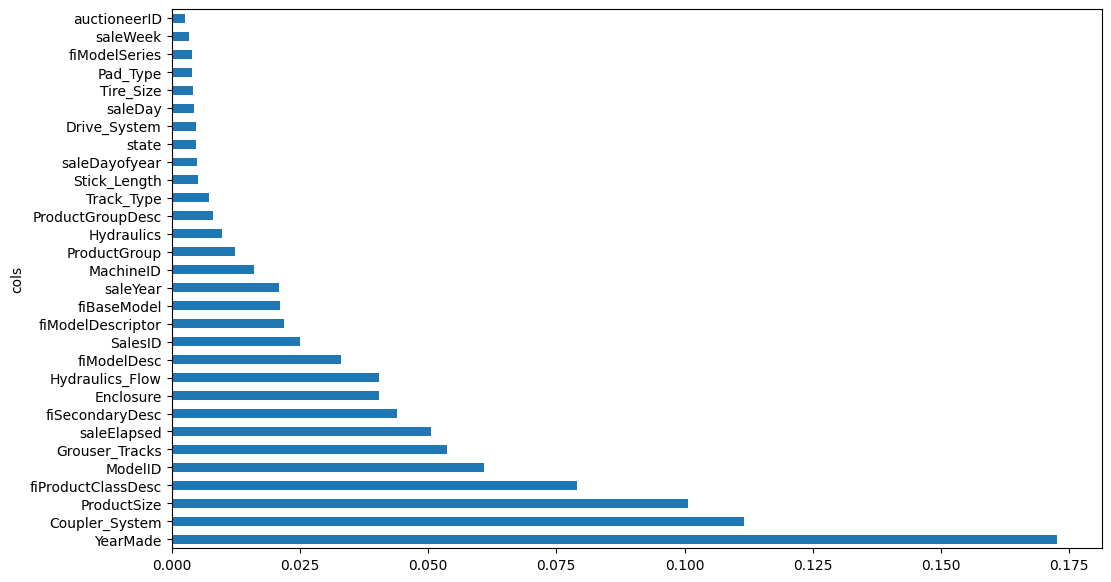

In [53]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [55]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]
m = rf(xs_imp, y)


In [56]:
len(xs.columns), len(xs_imp.columns)
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.179001, 0.232471)

In [59]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [60]:
get_oob(xs_imp)


0.8754241618905645

In [61]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8739497511864207,
 'saleElapsed': 0.8709200264023366,
 'ProductGroupDesc': 0.8743154332431271,
 'ProductGroup': 0.8748557125478201,
 'fiModelDesc': 0.8732519430169987,
 'fiBaseModel': 0.8727848729252328,
 'Hydraulics_Flow': 0.8747554891015421,
 'Grouser_Tracks': 0.8752388010074503,
 'Coupler_System': 0.8744216666248972}

In [62]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8728260547736328

In [63]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [64]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.180489, 0.233963)

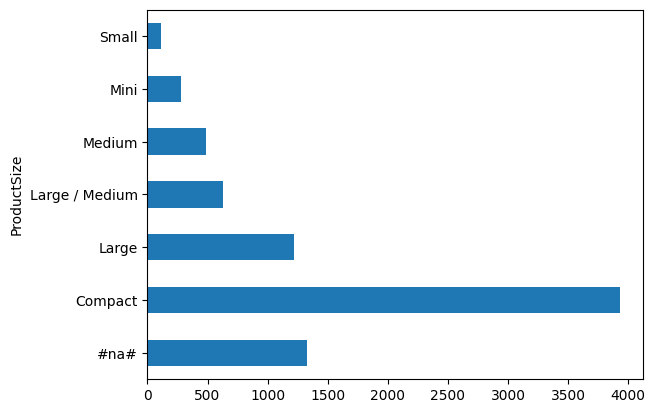

In [65]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

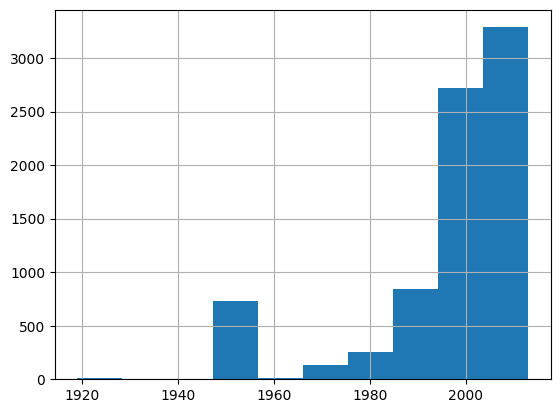

In [66]:
ax = valid_xs_final['YearMade'].hist()

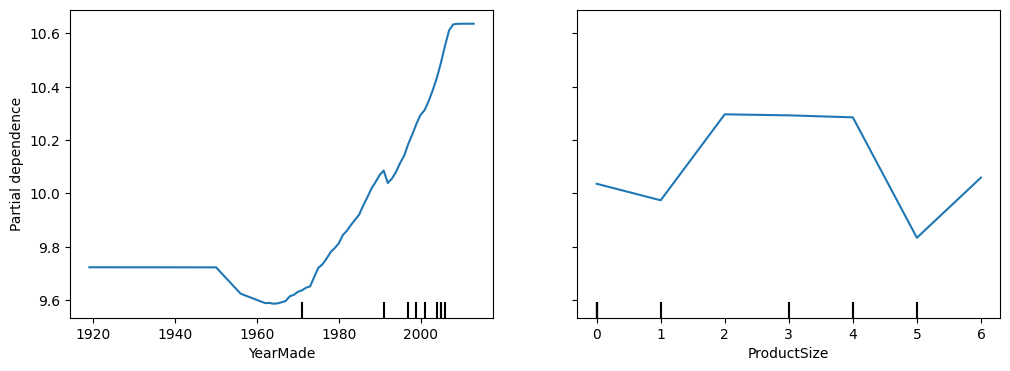

In [68]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(m, valid_xs_final, ['YearMade','ProductSize'],ax=ax)
